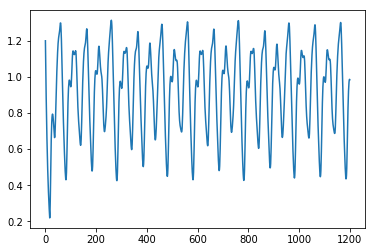

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Read Mackey-Glass data
# see http://www.scholarpedia.org/article/Mackey-Glass_equation

with open('mgdata.dat.txt') as f:
    data = map(lambda l: float(l.split(' ')[1]), f.readlines())

_=plt.plot(data)

In [3]:
from esn_cell import ESNCell
import numpy as np

washout_size=50
units=30

# build the graph and evaluate it
tf.reset_default_graph()   # so multiple evaluations won't fail

data_t = tf.reshape(tf.constant(data), [1, -1, 1])   # reshaped for dynamic_rnn: [batch, time, elements]

esn = ESNCell(num_units=units, connectivity=0.2, wr2_scale=0.7)
states_t, _ = tf.nn.dynamic_rnn(esn, data_t, dtype=tf.float32)
washed_t = tf.reshape(states_t[:, washout_size:, :], [-1, units])

with tf.Session() as S:
    tf.global_variables_initializer().run()
    states = np.mat(washed_t.eval())

In [4]:
tr_size=500     # we train on the first 500 samples to perform next step prediction
beta_ridge=1    # with lower beta, 0.01, it fits much better. You can't see the difference in the plot

# train data
tr_states = states[:tr_size]
tr_target = np.expand_dims(data[washout_size+1:tr_size+washout_size+1], axis=0)

# test
ts_states = states[tr_size:]
ts_target = np.mat(data[washout_size+tr_size+1:]).transpose()

# ridge regression to compute the output projection
wout = tr_target * tr_states * np.linalg.inv(np.transpose(tr_states) * tr_states + beta_ridge*np.eye(states.shape[1]))
wout = wout.transpose()

ts_out = (ts_states * wout)[:-1]

ts_mse = np.mean(np.square(ts_target - ts_out))
print("Test MSE: %f" % ts_mse)

Test MSE: 0.001225


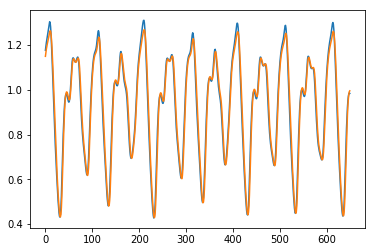

In [5]:
%matplotlib inline
_=plt.plot(ts_target)
_=plt.plot(ts_out)